In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import tensorflow as tf
import keras as keras
plt.style.use('ggplot')

In [5]:
codes = {}
codes['US'] = 'USGG10YR'
codes['Germany'] = 'GDBR10'
codes['UK'] = 'GUKG10'
codes['France'] = 'GFRN10'
codes['Australia'] = 'GACGB10'
codes['Canada'] = 'GCAN10YR'
codes['New Zealand'] = 'GNZGB10'
codes['Japan'] = 'JGBS10'
codes['Switzerland'] = 'GSWISS10'
codes['Norway'] = 'GNOR10YR'
codes['Italy'] = 'GBTPGR10'

sheet_names = pd.ExcelFile('G10_RV.xlsx').sheet_names[:11]
dfs = {x: pd.read_excel('G10_RV.xlsx', sheet_name=x)[['Date', 'Last Price']].rename(columns={'Last Price': x}) for x in sheet_names}
df = pd.DataFrame({'Date': dfs[sheet_names[0]]['Date']})  

for key in dfs:
    df = pd.merge(df, dfs[key], on='Date', how='outer')

df = df.set_index('Date').resample('D').asfreq().ffill().dropna()
df.iloc[[0,-1],:]

,USGG10YR,GDBR10,GUKG10,GFRN10,GACGB10,GCAN10YR,GNZGB10,JGBS10,GSWISS10,GNOR10YR,GBTPGR10
Date,,,,,,,,,,,
2010-01-05,3.7608,3.373,4.016,3.592,5.621,3.565,5.843,1.329,2.009,4.147,4.101
2024-04-12,4.5216,2.359,4.137,2.865,4.266,3.649,4.839,0.864,0.739,3.707,3.762


In [6]:
def predictor(method, target, t):
    data = df.copy()
    target = codes[target]
    target_t = f'{target}_{t}'
    ts = [1,5,10,25,50,100]

    for x in data:
        for z in ts:
            data[f'{x}_{z}'] = df[x].diff(z)

    data = data.dropna()
    cutoff = '2020-1-1'
    training = data[data.index < cutoff]
    testing = data[data.index > cutoff]

    if method == 'simple' or method == 'multi':
        if method == 'simple':
            training_X = training[[x for x in training if x.endswith(f'_{t}') and not x.startswith(target)]]
            training_y = training[target_t]
            testing_X = testing[[x for x in testing if x.endswith(f'_{t}') and not x.startswith(target)]]
            testing_y = testing[target_t]
        if method == 'multi':
            training_X = training[[x for x in training if '_' in x and x != target_t]]
            training_y = training[target_t]
            testing_X = testing[[x for x in testing if '_' in x and x != target_t]]
            testing_y = testing[target_t]
    
        model = LinearRegression()
        model.fit(training_X, training_y)
        training_prediction = model.predict(training_X)
        testing_prediction = model.predict(testing_X)
        training_accuracy = round(r2_score(training_y, training_prediction), 2)
        testing_accuracy = round(r2_score(testing_y, testing_prediction), 2)
        prediction = pd.DataFrame(testing[target].copy())
        prediction['c_prediction'] = testing_prediction
        prediction['prediction'] = prediction[target].shift(t) + prediction['c_prediction']
        prediction = prediction[[target, 'prediction']].dropna()
        return prediction, training_accuracy, testing_accuracy
    
    elif method == 'neural':
        training_X = training[[x for x in training if '_' in x and x != target_t]]
        training_y = training[target_t]
        testing_X = testing[[x for x in testing if '_' in x and x != target_t]]
        testing_y = testing[target_t]
        scaler = StandardScaler()
        training_X = scaler.fit_transform(training_X)
        testing_X = scaler.transform(testing_X)
        model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(64, activation='relu', input_shape=[training_X.shape[1]]),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        model.fit(training_X, training_y, epochs=200, validation_split=0.2, callbacks=[early_stopping], verbose=0)
        training_prediction = model.predict(training_X)
        testing_prediction = model.predict(testing_X)
        training_accuracy = round(r2_score(training_y, training_prediction), 2)
        testing_accuracy = round(r2_score(testing_y, testing_prediction), 2)
        prediction = pd.DataFrame(testing[target].copy())
        prediction['c_prediction'] = testing_prediction
        prediction['prediction'] = prediction[target].shift(t) + prediction['c_prediction']
        prediction = prediction[[target, 'prediction']].dropna()
        return prediction, training_accuracy, testing_accuracy

def performance(t):
    performances = pd.DataFrame()
    performances['Country'] = codes.keys()
    performances['r2: Simple'] = performances['Country'].apply(lambda x: predictor('simple', x, t)[2])
    performances['r2: Multi'] = performances['Country'].apply(lambda x: predictor('multi', x, t)[2])
    performances['r2: Neural'] = performances['Country'].apply(lambda x: predictor('neural', x, t)[2])
    performances = performances.set_index('Country')
    simple_mean = round(performances['r2: Simple'].mean(), 2)
    multi_mean = round(performances['r2: Multi'].mean(), 2)
    nn_mean = round(performances['r2: Neural'].mean(), 2)
    performances.loc['Mean'] = {'r2: Simple': simple_mean, 'r2: Multi': multi_mean, 'r2: Neural': nn_mean}
    return performances

performance(10)

Epoch 1/200


/Users/jv/anaconda3/envs/neural_network/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7608 - val_loss: 0.0301
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.1349 - val_loss: 0.0134
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 0.0638 - val_loss: 0.0090
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 0.0411 - val_loss: 0.0075
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0292 - val_loss: 0.0067
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 0.0252 - val_loss: 0.0061
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.0172 - val_loss: 0.0058
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 0.0152 - val_loss: 0.0054
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0151 - val_loss: 0.0047
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.0125 - val_loss: 0.0047
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.0128 - val_loss: 0.0040
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step -

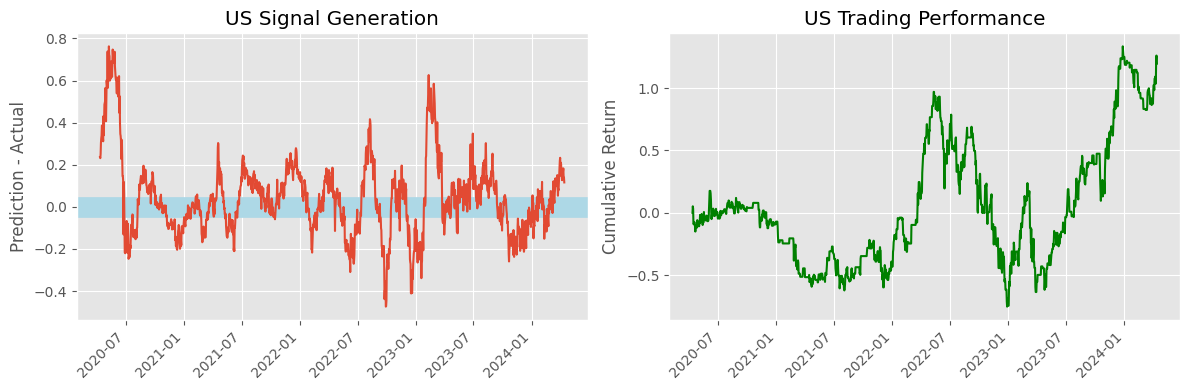

1.2

In [ ]:
def trader(target, t, std):
    data = predictor('multi', target, t)[0]
    name = target
    target = codes[target]
    data['spread'] = data['prediction'] - data[target]
    threshold = data['spread'].std() * std
    data['signal'] = 0
    data.loc[data[target] > data['prediction'] + threshold , 'signal'] = -1
    data.loc[data[target] < data['prediction'] - threshold, 'signal'] = 1
    data['return'] = data[target].diff(1)
    data['signal_return'] = data['return'] * data['signal']
    data['cum_return'] = data['signal_return'].cumsum()
    total_return = round(list(data['cum_return'])[-1], 2)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(data.index, data['spread'], label='Spread')
    axs[0].axhspan(-threshold, threshold, color='lightblue', alpha=1)
    axs[0].set_ylabel('Prediction - Actual')
    axs[0].set_title(f'{name} Signal Generation')
    axs[1].plot(data.index, data['cum_return'], label='Cumulative Return', color='green')
    axs[1].set_ylabel('Cumulative Return')
    axs[1].set_title(f'{name} Trading Performance')
    date_format = DateFormatter('%Y-%m')
    axs[0].xaxis.set_major_formatter(date_format)
    axs[1].xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()
    return total_return

trader('US', 100, .25)

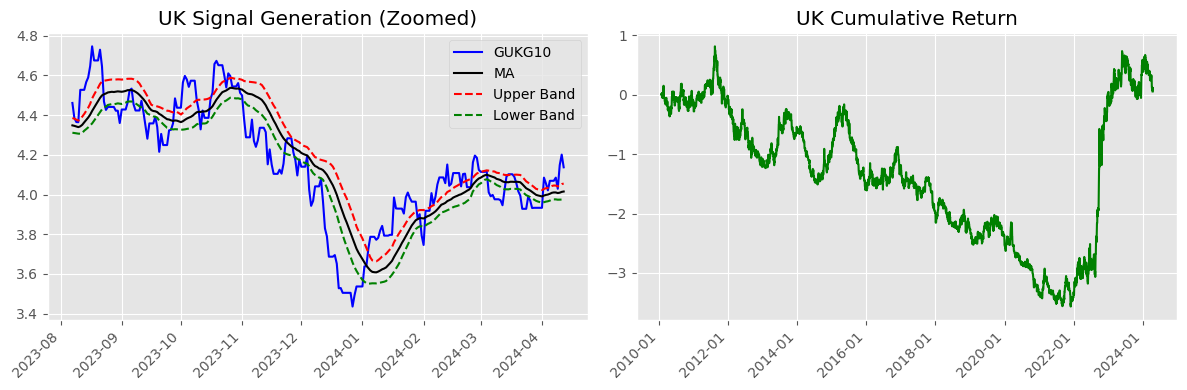

0.05

In [ ]:
def momentum(ticker, window, stds):
    name = ticker
    ticker = codes[ticker]
    data = df[[ticker]].copy()
    data['MA'] = data[ticker].rolling(window).mean()
    data['upper'] = data['MA'] + data[ticker].rolling(window).std() * stds
    data['lower'] = data['MA'] - data[ticker].rolling(window).std() * stds
    data = data.dropna()
    data['signal'] = 0
    data.loc[data[ticker] > data['upper'], 'signal'] = 1
    data.loc[data[ticker] < data['lower'], 'signal'] = -1
    data['signal'] = data['signal'].shift(1)
    data['return'] = data[ticker].diff(1)
    data['signal_return'] = data['return'] * data['signal']
    data['cum_return'] = data['signal_return'].cumsum()
    total_return = round(list(data['cum_return'])[-1], 2)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(data.index[-250:], data[ticker].iloc[-250:], label=ticker, color='blue')
    axs[0].plot(data.index[-250:], data['MA'].iloc[-250:], label='MA', color='black')
    axs[0].plot(data.index[-250:], data['upper'].iloc[-250:], label='Upper Band', linestyle='--', color='red')
    axs[0].plot(data.index[-250:], data['lower'].iloc[-250:], label='Lower Band', linestyle='--', color='green')
    axs[0].set_title(f"{name} Signal Generation (Zoomed)")
    axs[0].legend()
    axs[1].plot(data.index, data['cum_return'], label='Trading Performance', color='green')
    axs[1].set_title(f'{name} Cumulative Return')
    date_format = DateFormatter('%Y-%m')
    axs[0].xaxis.set_major_formatter(date_format)
    axs[1].xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()
    return total_return

momentum('UK', 25, .5)

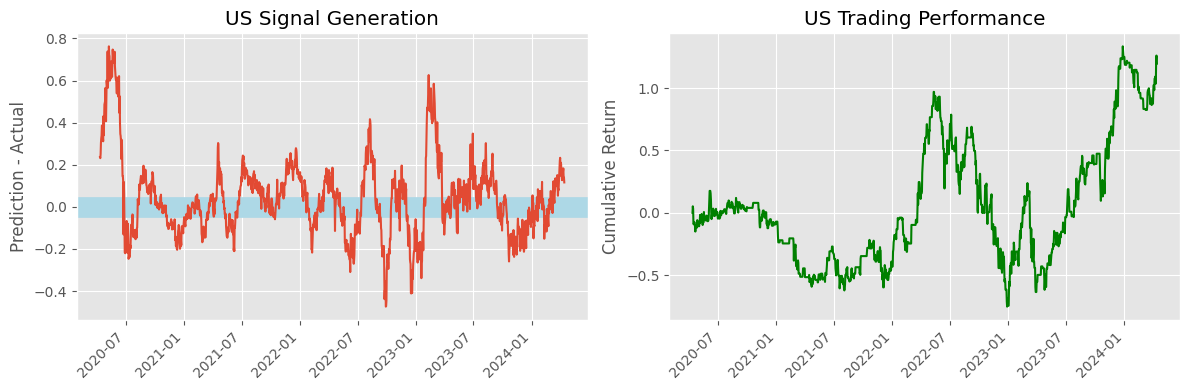

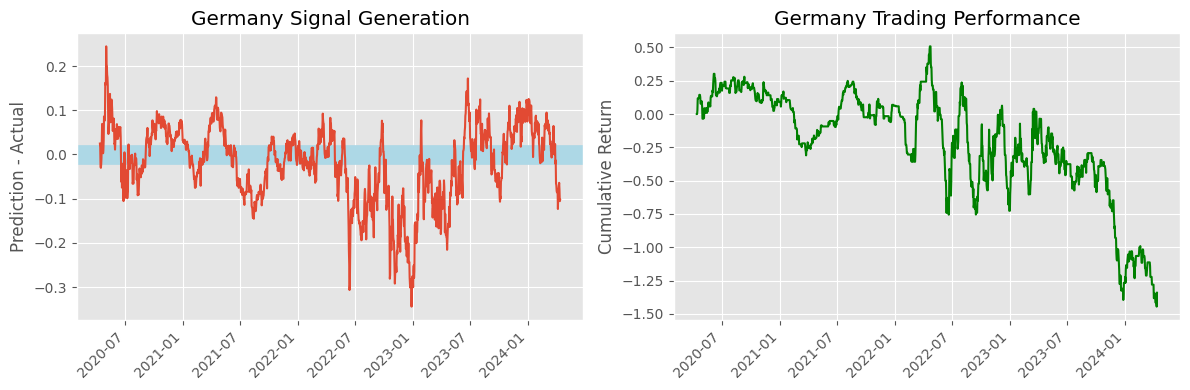

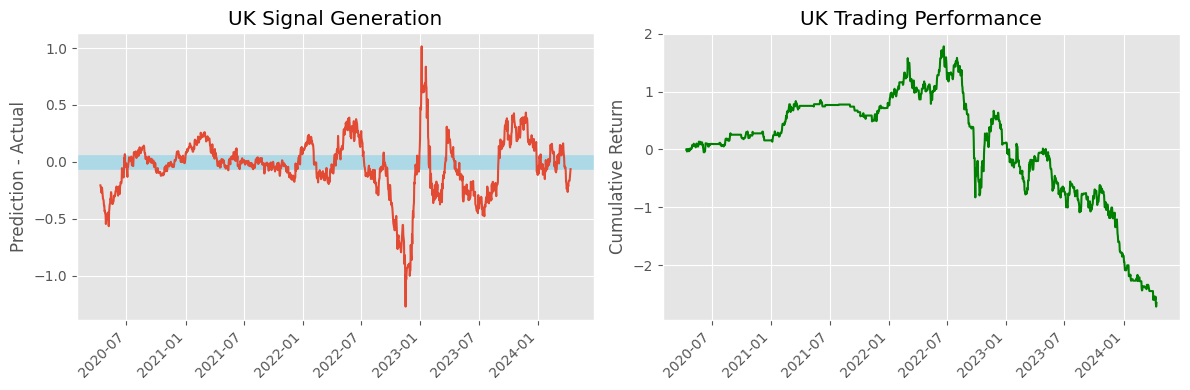

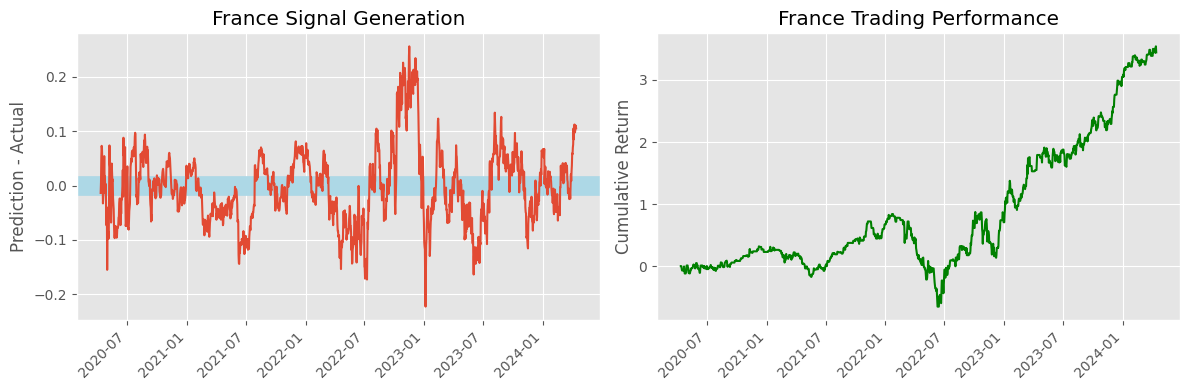

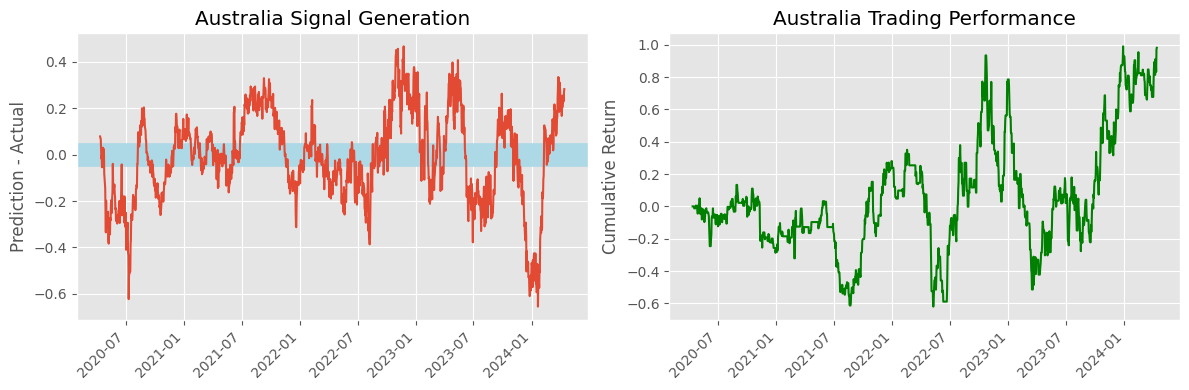

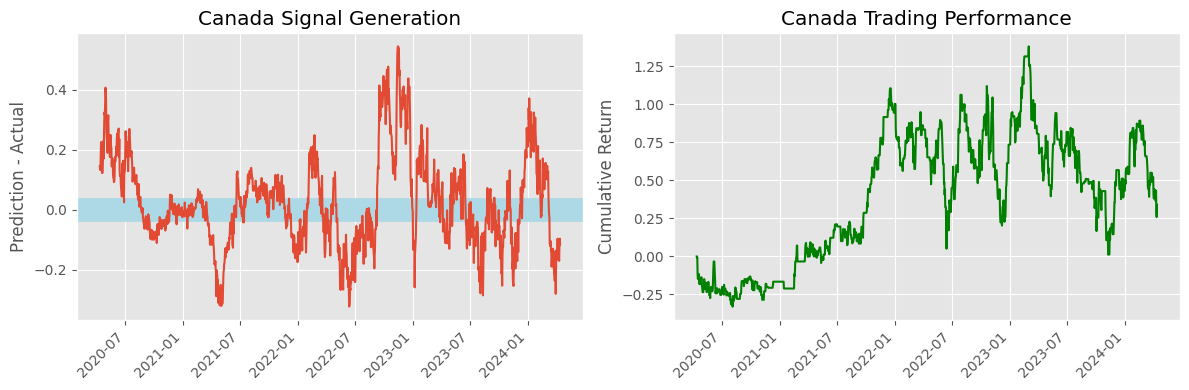

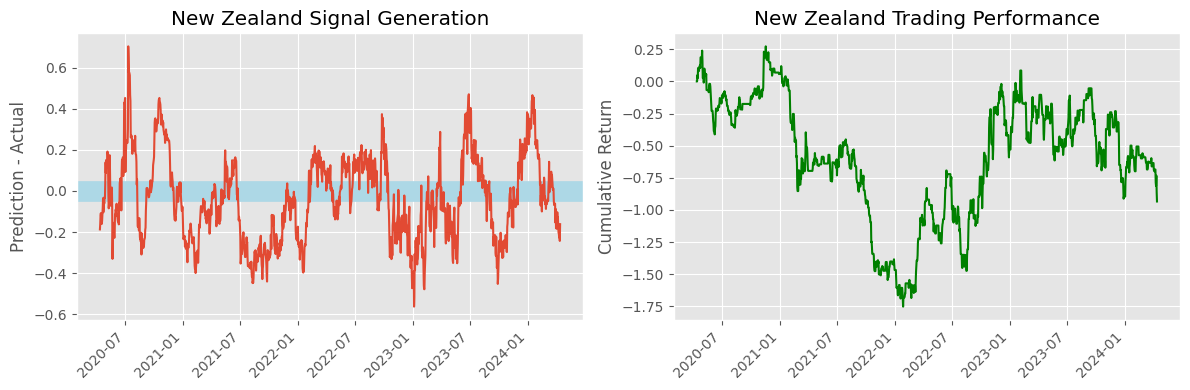

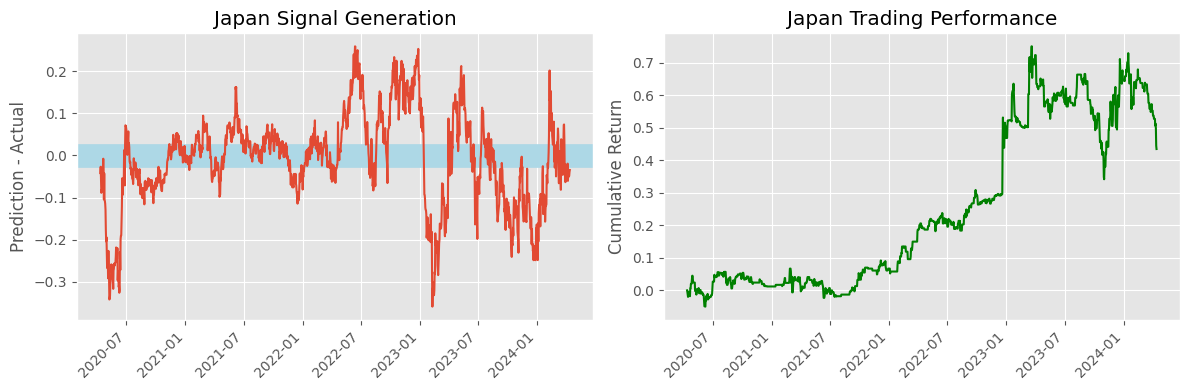

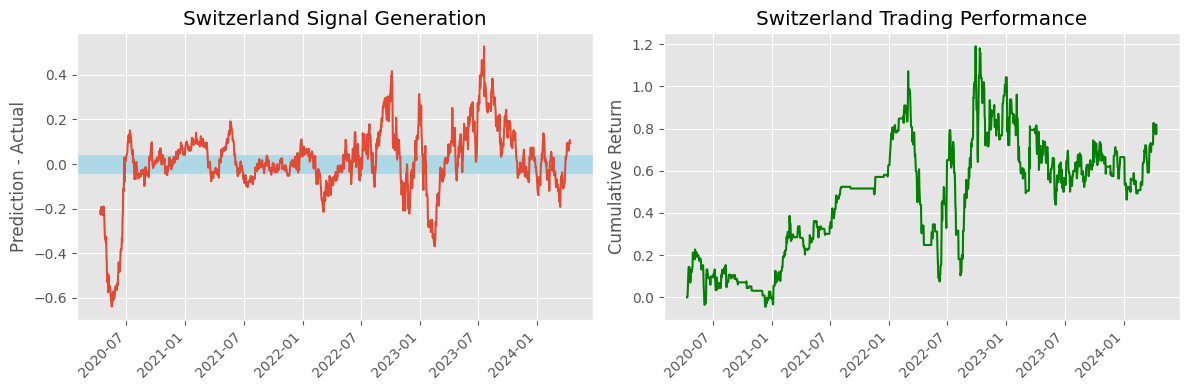

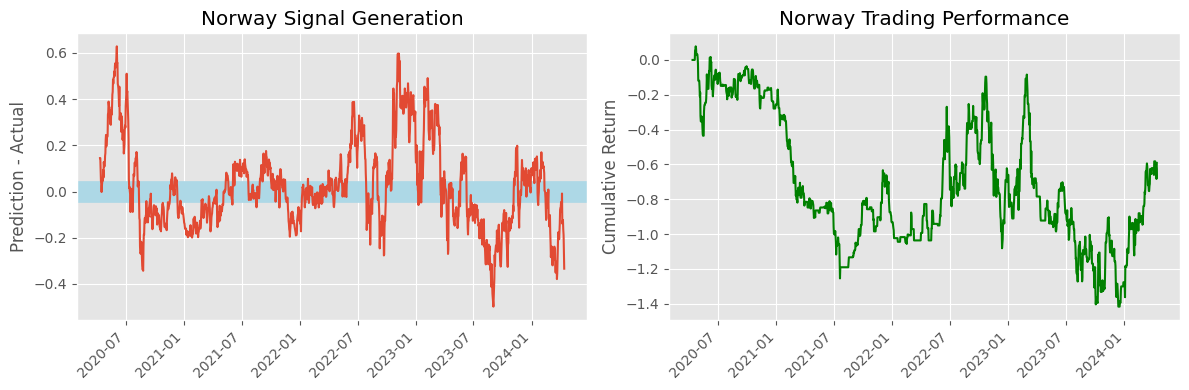

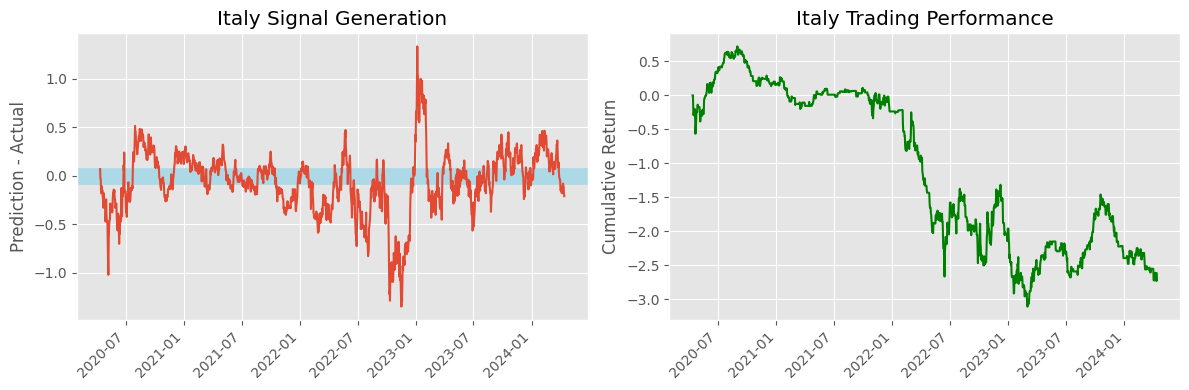

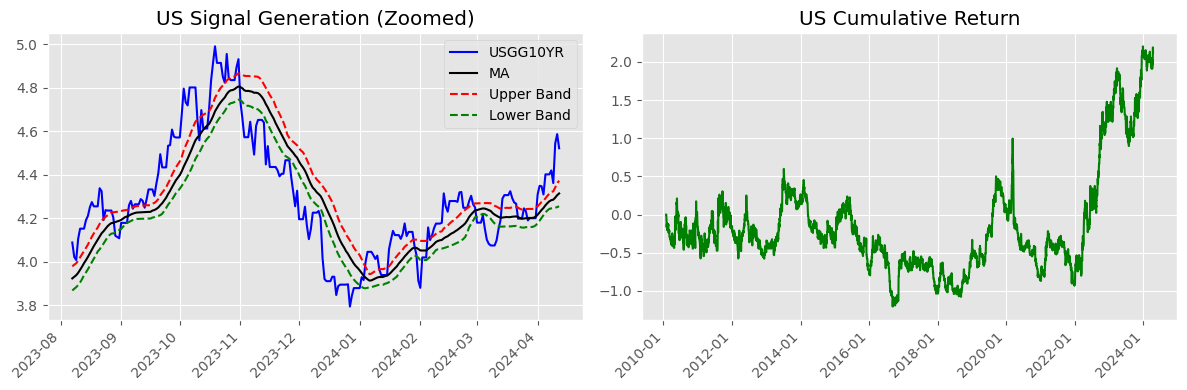

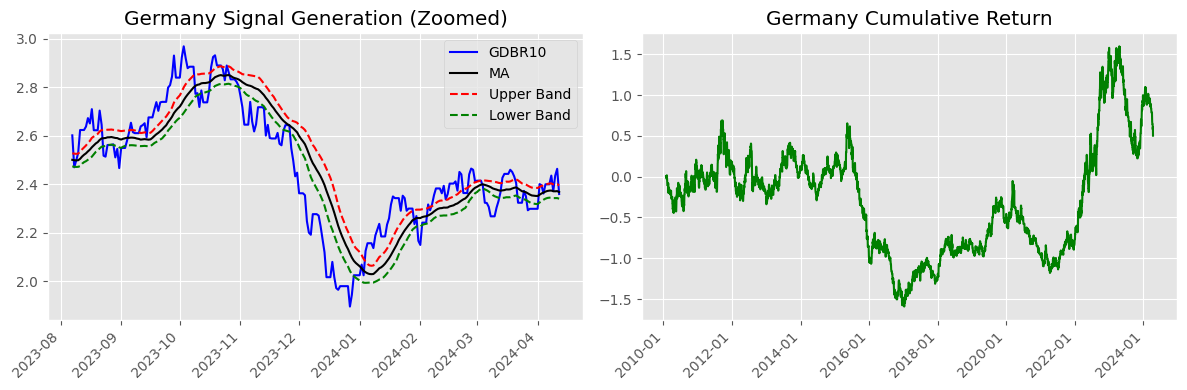

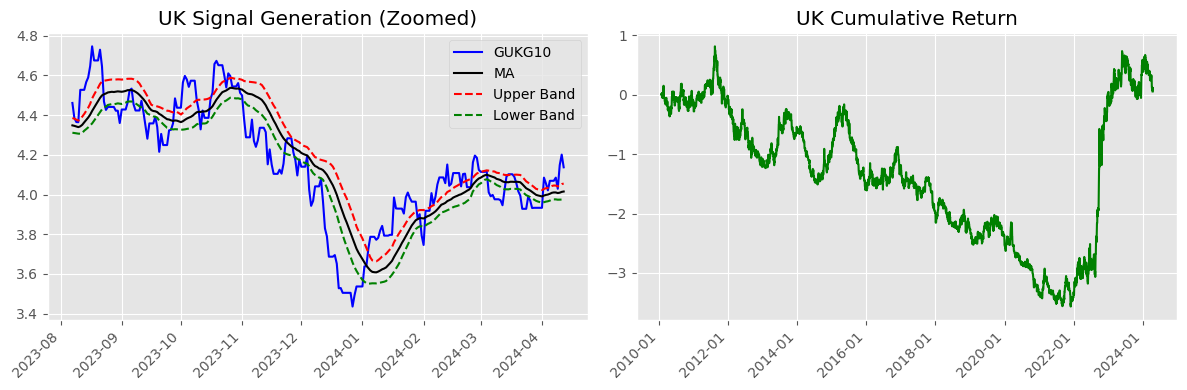

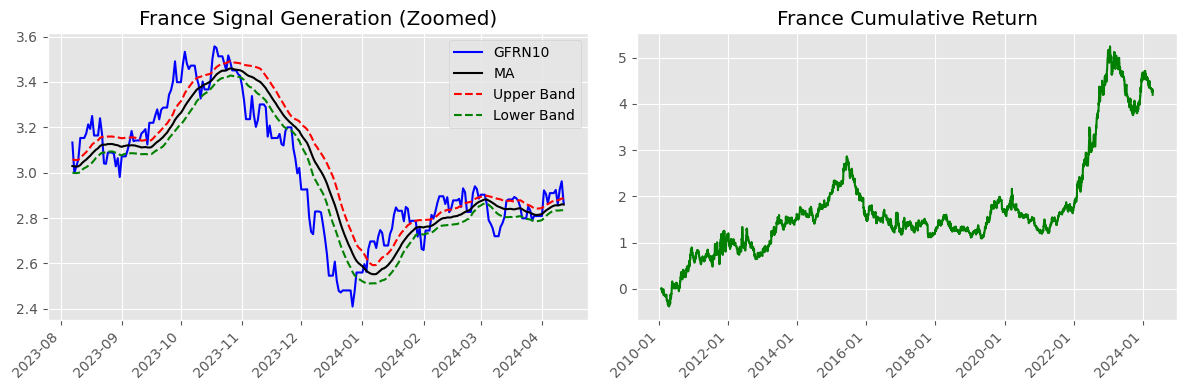

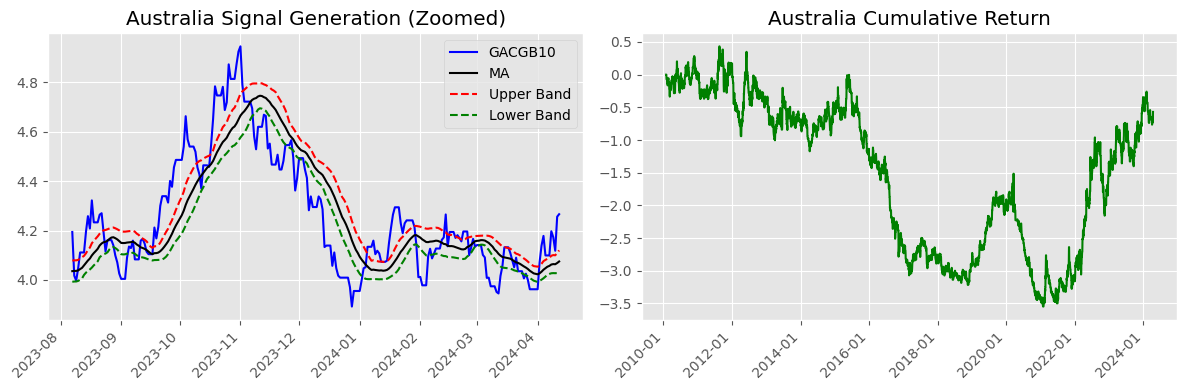

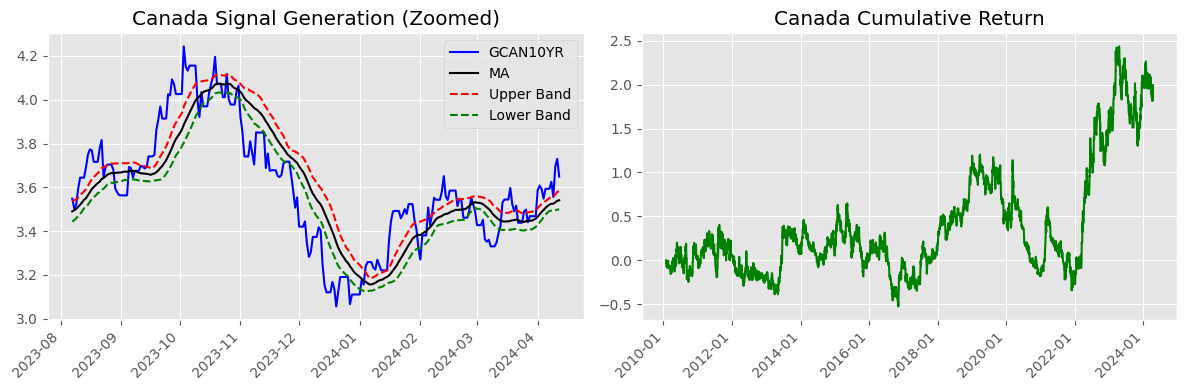

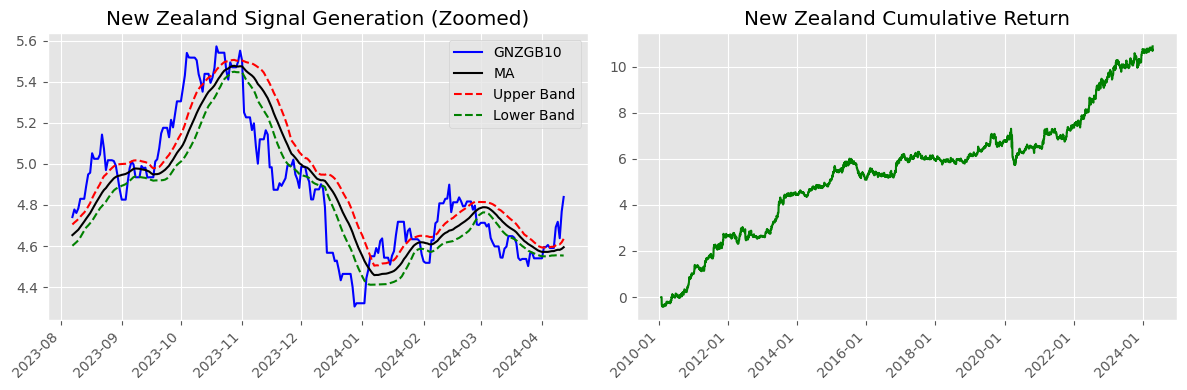

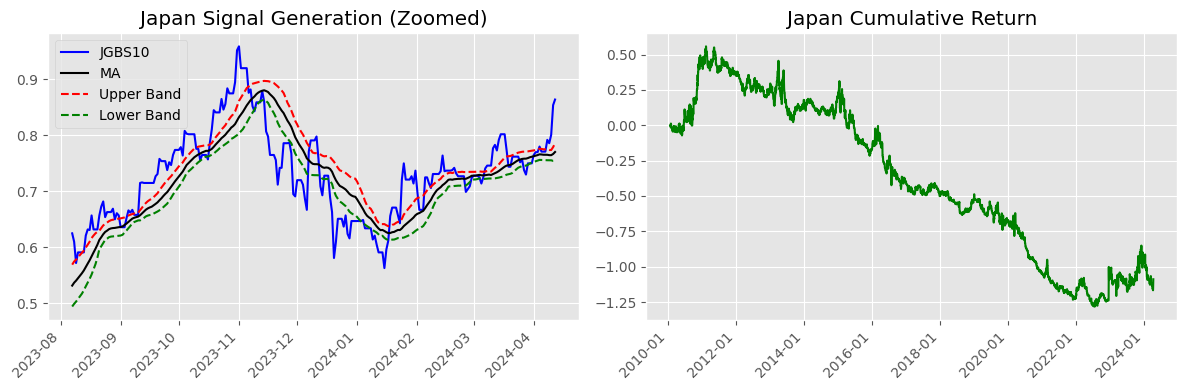

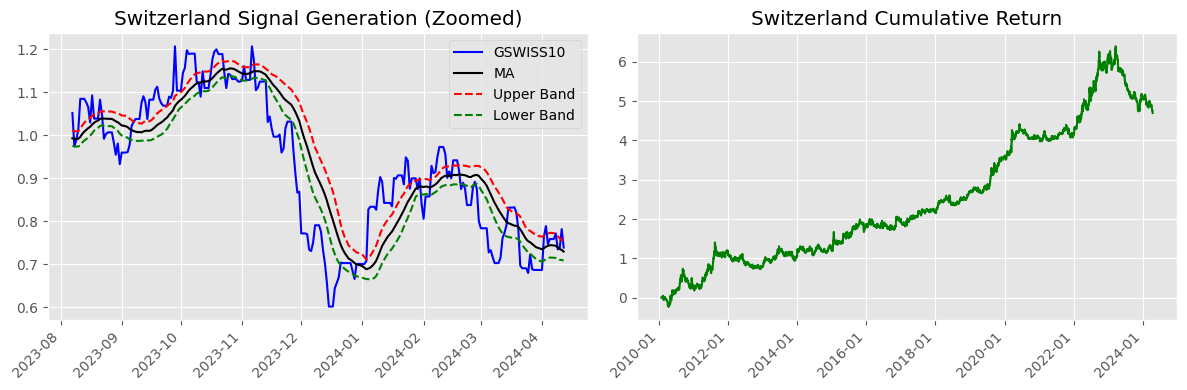

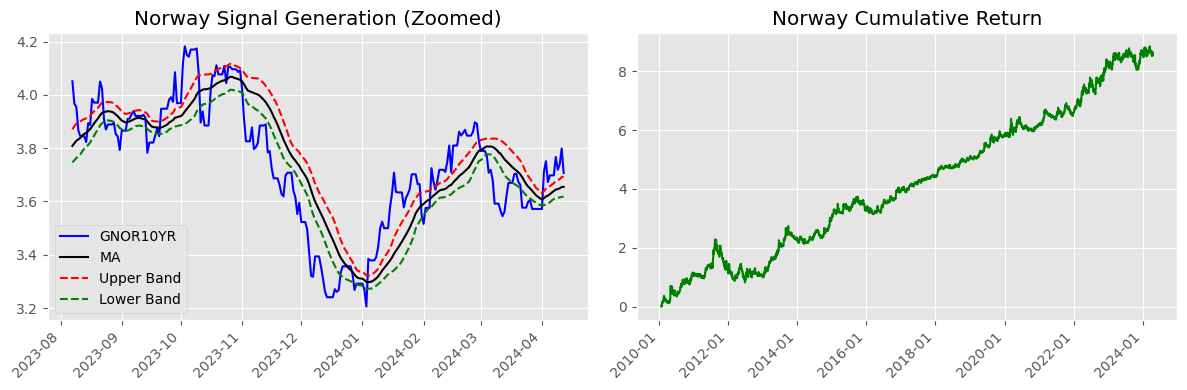

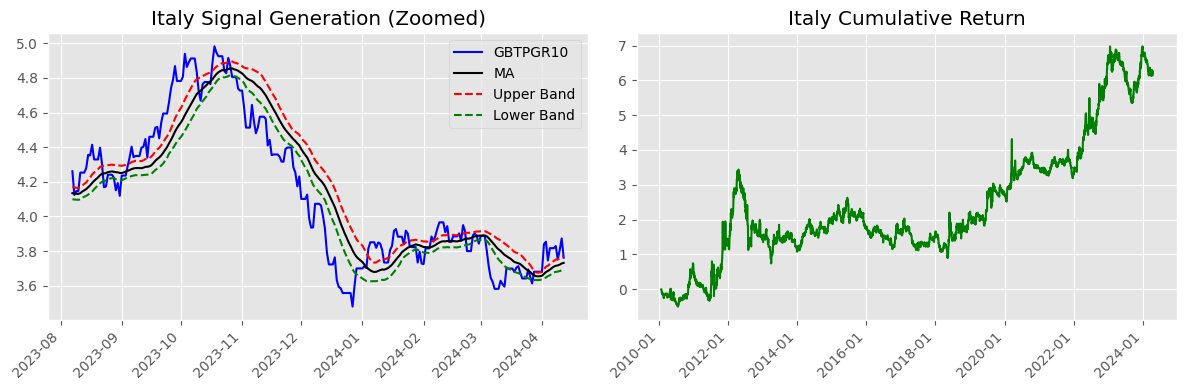

In [ ]:
trading = pd.DataFrame()
trading['Country'] = codes.keys()
trading['Predictive'] = trading['Country'].apply(lambda x: trader(x, 100, .25))
trading['Momentum'] = trading['Country'].apply(lambda x: momentum(x, 25, .5))
trading = trading.set_index('Country')
trading.loc['Mean'] = round(trading.mean(), 2)

In [ ]:
trading

,Predictive,Momentum
Country,,
US,1.20,2.13
Germany,-1.34,0.50
UK,-2.65,0.05
France,3.45,4.19
Australia,0.98,-0.57
Canada,0.34,1.92
New Zealand,-0.93,10.88
Japan,0.44,-1.09
Switzerland,0.78,4.70
